<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# Adaptation Statistique d'un Modèle de Prévision du Pic d'Ozone en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="R"/></a>

**Résumé**: Exploration puis modélisation de données climatiques en utilisant Pyhton et la librairie [Scikit-learn](http://scikit-learn.org/stable/#). L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales. Estimation par différentes méthodes: régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [k plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation de modèle](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf). Comparaison des [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un échantillon test puis des courbes ROC. Itération sur plusieurs échantillons tests pour analyser la distribution de l'erreur de prévision. Ce calepin vient compléter l'[étude faite avec R](http://www.math.univ-toulouse.fr/~besse/Wikistat/Notebooks/Notebook-R-Ozone.html) pour en comparer les deux approches.

## 1. Introduction

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* ou post-traitement d'une prévision locale de modèles à trop grande échelle en s'aidant d'autre variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). 

Ce calepin vient compléter [celui en R](http://www.math.univ-toulouse.fr/~besse/Wikistat/Notebooks/Notebook-R-Ozone.html) afin de comparer les performances respectives des deux environnements: complétude des résultats et efficacité du code. 

La question posée reste: quelle est la meilleure stratégie pour prévoir l'occurrence d'un pic de pollution. 

Comme avec R différentes méthodes sont testées : régression logistique, k plus proches voisins, arbre de décision, random forest, SVM.  Les réseaux de neurones n'interviendront que lorsque la version 0.18 de Scikit-learn sera stable donc diffusée.

**Question subsidiaire :** quand préférer R ou Python ? Python conduit a des résultats (conclusions) identiques à ceux de R, moins complets pour leur interprétation, mais beaucoup plus rapidement. Il s'agit des principales différences entre R pour "statisticien" et python pour "informaticien", on perd en interprétabilité mais on gagne en vitesse d'exécution. 

## 2. Prise en compte des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes:


* **JOUR** Le type de jour ; férié (1) ou pas (0) ;
* **O3obs** La concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** Température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** Rapport d'humidité ;
* **NO2** Concentration en dioxyde d'azote ;
* **NO** Concentration en monoxyde d'azote ;
* **STATION** Lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** Force du vent ;
* **VentANG** Orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent donc avant tout un caractère pédagogique.

Il est choisi ici de lire les données avec la librairie $pandas$ pour bénéficier de la classe DataFrame. Ce n'est pas nécessaire pour l'objectif de prévision car les variables qualitatives ainsi construites ne peuvent être utilisées pour l'interprétation des modèles obtenus dans scikit-learn qui ne reconnaît pas la classe DataFrame.

In [1]:
import pandas as pd
import numpy as np
# Lecture des données
## Charger les données ou les lire directement en précisant le chemin
path=""
#path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
ozone=pd.read_csv(path+"depSeuil.dat",sep=",",header=0)
# Vérification du contenu
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
0,1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
1,1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
2,0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
3,0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
4,0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822


Ce qui suit permet d'affecter le bon type aux variables.

In [2]:
ozone["STATION"]=pd.Categorical(ozone["STATION"],ordered=False)
ozone["JOUR"]=pd.Categorical(ozone["JOUR"],ordered=False)
ozone["O3obs"]=pd.DataFrame(ozone["O3obs"], dtype=float)
ozone.dtypes

JOUR       category
O3obs       float64
MOCAGE      float64
TEMPE       float64
RMH2O       float64
NO2         float64
NO          float64
STATION    category
VentMOD     float64
VentANG     float64
dtype: object

In [3]:
ozone.describe()

,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,VentMOD,VentANG
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,115.400576,127.219693,23.883381,0.010251,3.504645,0.657417,5.907186,0.163111
std,40.999155,39.820186,5.217462,0.003731,4.043308,0.844180,3.054307,0.708288
min,19.000000,46.400000,10.400000,0.002850,0.258000,0.001000,0.141420,-1.570790
25%,87.000000,97.500000,20.200000,0.007630,1.248000,0.236000,3.962320,-0.394790
50%,109.000000,125.600000,23.800000,0.009850,2.109000,0.388000,5.597300,0.278300
75%,135.000000,153.600000,27.600000,0.012440,4.062000,0.744000,7.106300,0.692640
max,319.000000,284.700000,38.000000,0.027530,44.396000,9.429000,19.891000,1.570790


## 3. Exploration

Même si les données ne présentent pas de défauts particuliers, une étude exploratoire préliminaire est indispensable afin de s'ssurer le leur bonne cohérence, proposer d'éventuelles transformations et analyser les structures de corrélations ou plus généralement de liaisons entre les variables, de groupes des individus ou observations.

### 3.1 Unidimensionnelle

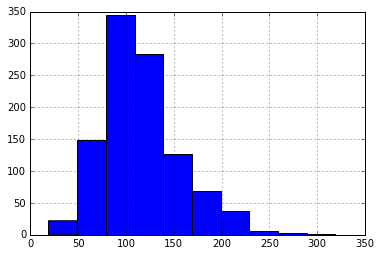

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
ozone["O3obs"].hist()
plt.show()

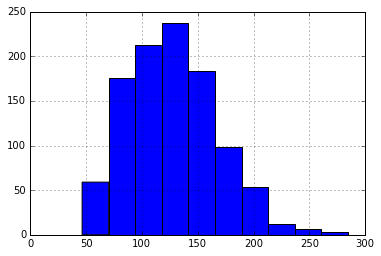

In [5]:
ozone["MOCAGE"].hist()
plt.show()

Traiter ainsi toutes les variables. Ceci suggère des transformations. 

In [6]:
from math import sqrt, log
ozone["SRMH2O"]=ozone["RMH2O"].map(lambda x: sqrt(x))
ozone["LNO2"]=ozone["NO2"].map(lambda x: log(x))
ozone["LNO"]=ozone["NO"].map(lambda x: log(x))
del ozone["RMH2O"]
del ozone["NO2"]
del ozone["NO"]

**Exo:** Vérifier l'opportunité de ces transformations (histogrames des nouvelles variables).

Retirer les variables initiales et construire ci-dessous la variable "dépassement de seuil" pour obtenir le fichier qui sera effectivement utilisé.

In [7]:
ozone["DepSeuil"]=ozone["O3obs"].map(lambda x: x > 150)
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
0,1,91,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022,False
1,1,100,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993,False
2,0,82,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426,False
3,0,94,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247,False
4,0,107,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073,False


### 3.2 Exploration multidimensionnelle

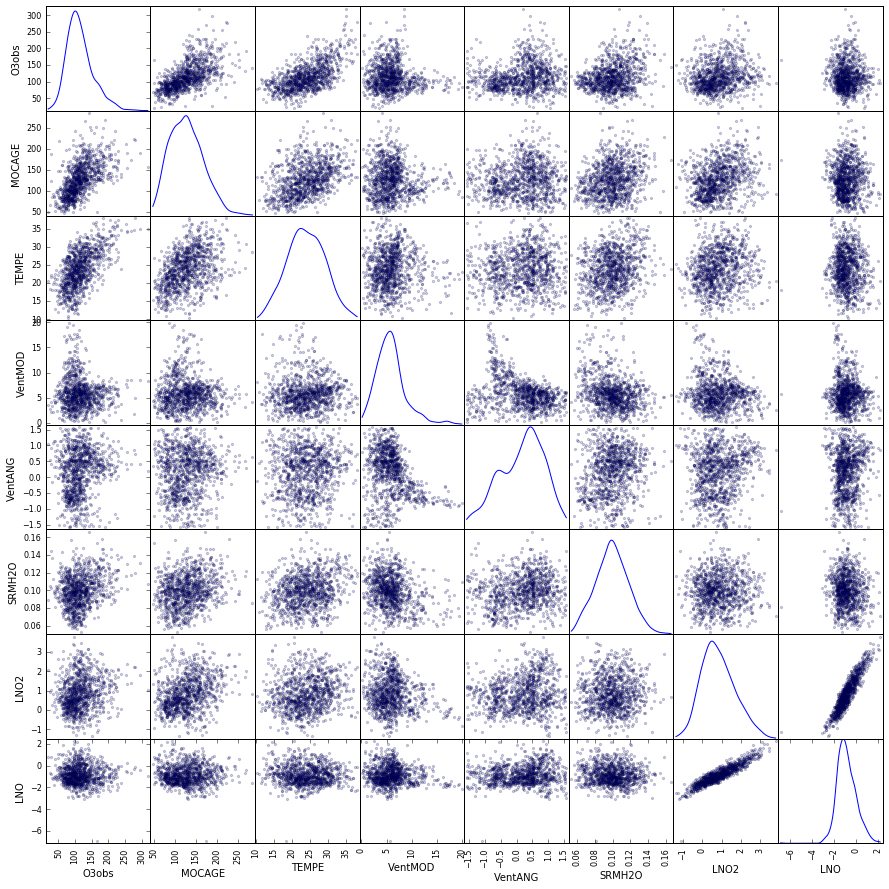

In [8]:
# scatter plot matrix des vaiables quantitatives
from pandas.tools.plotting import scatter_matrix
scatter_matrix(pd.DataFrame(ozone[[1,2,3,5,6,7,8,9]]), alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

**Question:** Que dire des relations entre les variables prises 2 à 2 ?

### 3.3 [Analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf)

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
# réduction des variables
X=scale(pd.DataFrame(ozone[[2,3,5,6,7,8,9]]))

Tous les résultats numétriques classiques sont fournis par l'[implémentation](http://scikit-learn.org/stable/modules/decomposition.html) de scikit-learn mais des  efforts sont à produire pour construire les graphiques usuels généralement automatiquement produits par des librairies dédiées comme [FactoMineR](http://factominer.free.fr/) de R.

Les commandes suivantes permettent de réaliser une analyse en composantes principales sur les seules variables quantitatives. Par ailleurs la variable à modéliser  (O3obs, concentration observée) n'est pas utilisée.

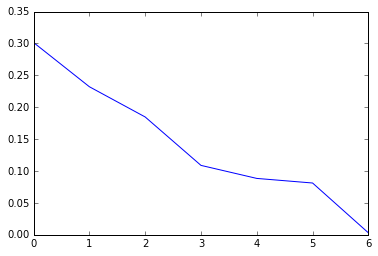

In [10]:
pca = PCA()
## Estimation, calcul des composantes principales
C = pca.fit(X).transform(X)
## Décroissance de la variance expliquée
plt.plot(pca.explained_variance_ratio_)
plt.show()

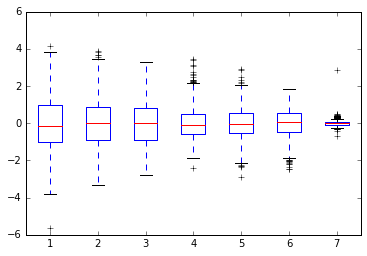

In [11]:
## distribution des composantes principales
plt.boxplot(C[:,0:20])
plt.show()

**Question:** Que sont ces graphiques ? Que dire du choix de la dimension, des valeurs atypiques?

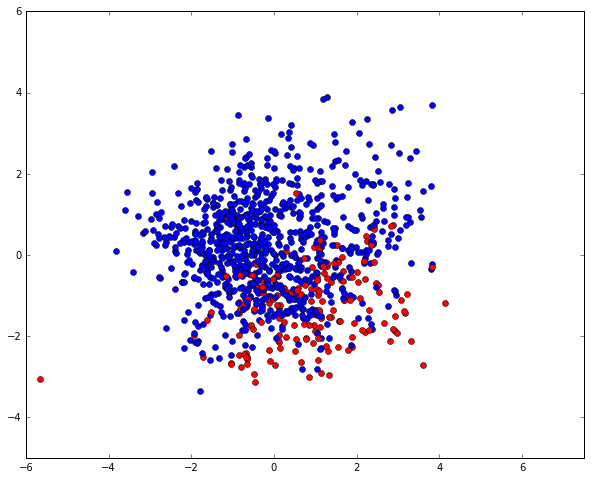

In [12]:
## Repésentation des individus
plt.figure(figsize=(10,8))
for i, j, nom in zip(C[:,0], C[:,1], ozone["DepSeuil"]):
    color = "red" if nom  else "blue"
    plt.plot(i, j, 'o',color=color)
plt.axis((-6,7.5,-5,6))  
plt.show()

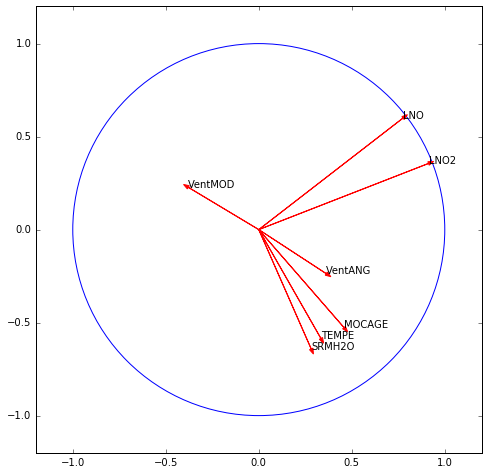

In [13]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, ozone[[2,3,5,6,7,8,9]].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

**Questions:** Que dire de la structure de corrélation des variables ? Est-elle intuitive ? L'objectif est de définir une surface séparant les deux classes. Une discriminaiton linéaire (hyperplan) semble-t-elle possible?

Ce n'est pas utile ici mais une classification non supervisée est facile à obtenir à titre illustratif, par exemple en 4 classes, par l'algorithme k-means:

In [14]:
from sklearn.cluster  import  KMeans
from  sklearn.metrics  import confusion_matrix
clust=KMeans(n_clusters=4)
clust.fit(X)
classe=clust.labels_
print(classe)

[2 2 2 ..., 3 1 0]


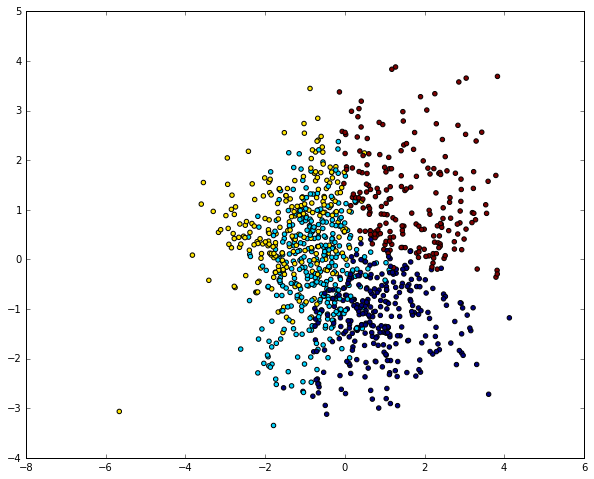

In [15]:
## Repésentation des individus dans les coordonnées de l'acp.
plt.figure(figsize=(10,8))
plt.scatter(C[:,0], C[:,1], c=classe) 
plt.show()

## 4. Modélisations

La recherche  d'une meilleure méthode de prévision suit généralement le protocole suivant dont la première étape est déja réalisée.


1. Etape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par *validation croisée*.
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation, 
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

**Remarques**
* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test, afin de réduire la variance (moyenne) des estimations des erreurs de prévision.
* *Attention*: ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test !
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...
* L'étape "choix" de la meilleure méthode peut être remplacée par une combinaisons de prévision comme c'est souvent le cas dans les soutions "gagnantes" mais lourdes du site [kaggle](https://www.kaggle.com/competitions).

### 4.1 Extraction des échantillons apprentissage et test

Transformation des données pour l'apprentissage. Les variables qualitatives sont transformées en paquets d'indicatrices ou *dummy variables* et le type data frame en une matrice. Il est parfois utile, en vue de certaines modélisations de centrer et réduire les variables quantitatives (SVM).

In [16]:
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
0,1,91,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022,False
1,1,100,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993,False
2,0,82,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426,False
3,0,94,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247,False
4,0,107,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073,False


In [17]:
# Variables explicatives
ozoneDum=pd.get_dummies(ozone[["JOUR","STATION"]])
del ozoneDum["JOUR_0"]
ozoneQuant=ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]]
dfC=pd.concat([ozoneDum,ozoneQuant],axis=1)
dfC.head()

,JOUR_1,STATION_Aix,STATION_Als,STATION_Cad,STATION_Pla,STATION_Ram,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,1,1,0,0,0,0,93.2,21.5,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,1,1,0,0,0,0,104.6,20.2,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,0,1,0,0,0,0,103.6,17.4,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,0,1,0,0,0,0,94.8,18.8,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,0,1,0,0,0,0,99.0,23.7,7.8791,-0.41822,0.085499,0.502592,-0.794073


In [18]:
# variable à expliquer binaire
Yb=ozone["DepSeuil"].map(lambda x: int(x))
# variable à expliquer réelle
Yr=ozone["O3obs"]

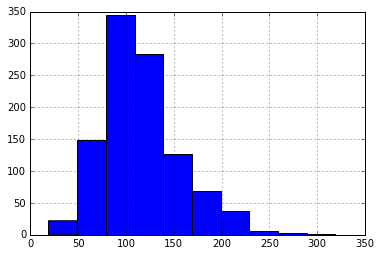

In [19]:
Yr.hist()
plt.show()

Extractions des échantillons d'apprentissage  et test pour les deux types de modèles. Comme le générateur est initalisé de façon identique, ce sont les mêmes échantillons dans les deux cas.

In [20]:
from sklearn.cross_validation  import train_test_split
X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=200,random_state=11)
X_train,X_test,Yr_train,Yr_test=train_test_split(dfC,Yr,test_size=200,random_state=11)

### 4.2 Modèles linéaires

Les fonctions de modéles linéaires et linéaires généralisées sont limitées dans [Scikit-learn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) et sans sorties numériques (tests) détaillées qui sont à rechercher dans une autre librairie ([StatsModels](http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/glm.html)). Dans les deux cas, les stratégies classiques (forward, backward, stepwise, Furnival et Wilson) de sélection de variables par optimisation d'un critère (Cp, AIC, BIC) ne semblent pas disponibles, même si AIC et BIC sont présents dans scikit-learn, et le type DataFrame (package *pandas*) n'est pas reconnu.

La façon efficace de procéder est donc d'introduire une [pénalisation Lasso](http://wikistat.fr/pdf/st-m-app-select.pdf) pour opérer une sélection de variables ou plutôt la sélection de variables quantitatives et d'indicatrices des modalités de celles qualitatives mais sans analyse fine des interactions comme cela est possible avec R.

A titre de comparaison, on trace la prévision de la concentration de l'échantillon test par la seule valeur du modèle *Mocage* ainsi que les résidus à ce modèle fonction de la valeur prédite (Mocage)

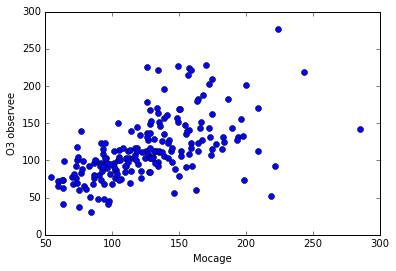

In [21]:
plt.plot(X_test["MOCAGE"],Yr_test,"o")
plt.xlabel("Mocage")
plt.ylabel("O3 observee")
plt.show()

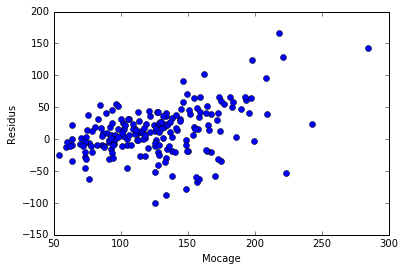

In [22]:
plt.plot(X_test["MOCAGE"],X_test["MOCAGE"]-Yr_test,"o")
plt.xlabel("Mocage")
plt.ylabel("Residus")
plt.show()

Commenter la qualité de ces résidus.

In [23]:
# Erreur quadratique moyenne
from sklearn.metrics import mean_squared_error
print("MSE=",mean_squared_error(X_test["MOCAGE"],Yr_test))

('MSE=', 1565.8692999999998)


#### [Régression linéaire](http://wikistat.fr/pdf/st-m-app-select.pdf) ou modèle gaussien

**Question**: Comparer cette prévision déterministe (équation de Navier et Stockes) par l'adaptation statistique la plus élémentaire. Il s'agit d'une régression avec choix de modèle par pénalisaiton LASSO, la valeur du paramètre est laissée par défaut (0.1).

In [24]:
from sklearn import linear_model
regLasso = linear_model.Lasso()
regLasso.fit(X_train,Yr_train)
prev=regLasso.predict(X_test)
print("MSE=",mean_squared_error(prev,Yr_test))

('MSE=', 871.56477300834638)


Le paramètre de pénalisation est optimisé par validation croisée.

In [52]:
from sklearn.grid_search import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.05,0.1,0.2,0.3,0.4,0.5,1]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(X_train, Yr_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]

0.4

Prévision avec la valeur optimale de alpha puis calcul et tracé des résidus.

In [53]:
prev=regLassOpt.predict(X_test)
print("MSE=",mean_squared_error(prev,Yr_test))

('MSE=', 859.25559724026232)


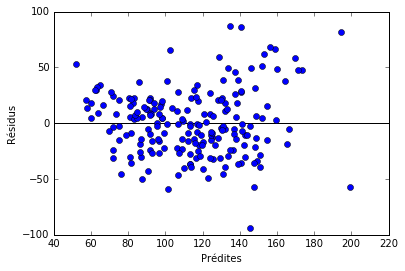

In [54]:
plt.plot(prev,Yr_test-prev,"o")
plt.xlabel(u"Prédites")
plt.ylabel(u"Résidus")
plt.hlines(0,40,220)
plt.show()

**Question:** Comparer ces résidus avec ceux précédents (mocage). Que dire de l'amélioration? Que suggère la forme du nuage sur la validité du modèle?

**Question:** L'interprétation nécessite le calcul des coefficients du modèle. Noter l'effet de la pénalisation; interpréter l'effet de chaque variable sur la concentration en ozone.

In [55]:
# Coefficients
regLasso=linear_model.Lasso(alpha=0.4)
regLasso.fit(X_train,Yr_train).coef_

array([ -0.        ,  -1.16114982,  -0.14913186,   3.60047575,
        12.33074519,  -0.        ,   0.34447881,   3.8125895 ,
        -1.10623206,   3.36272438,   0.        ,  -0.        ,   1.16812292])

C'est ici qu'apparaît l'insuffisance de la librairie python. Il faudrait construire "à la main" ou utiliser la librairie *Statsmodels* pour afficher les statistiques des tests et p-valeurs. Même avec avec ces compléments, la prise en compte des interactions et de leur sélection ne sont pas prévues. L'interprétation en est compliquée avec l'éclatement de chaque variable qualitative en paquets d'indicatrices.

Le graphe quivant permet d'identifier les bonnes et mauvaises prévisions de dépassement du seuil légal, ici fixé à $ 150 \mu g $.

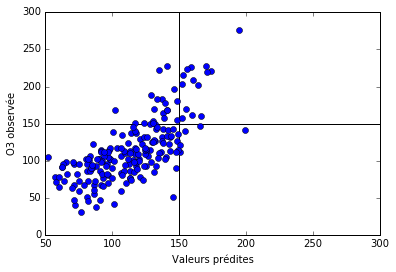

In [56]:
plt.plot(prev,Yr_test,"o")
plt.xlabel(u"Valeurs prédites")
plt.ylabel(u"O3 observée")
plt.hlines(150,50,300)
plt.vlines(150,0,300)
plt.show()

In [57]:
# Dénombrement des erreurs par
# matrice de confusion
table=pd.crosstab(prev>150,Yr_test>150)
print(table)

O3obs  False  True 
row_0              
False    162     19
True       5     14


**Question:** Observer l'asymétrie de cette matrice. A quoi est-elle due au moins en partie ?

#### Chemin de régularisation de la régression Lasso et elastic net

In [71]:
X = X_train
y = Yr_train
X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)
# Compute paths
eps = 5e-3  # the smaller it is the longer is the path

In [63]:
from sklearn.linear_model import LassoCV

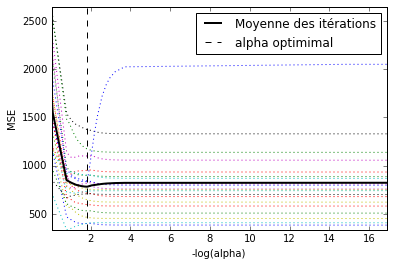

In [73]:
model = LassoLarsCV(cv=20).fit(X, y)
m_log_alphas = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphas, model.cv_mse_path_, ':')
plt.plot(m_log_alphas, model.cv_mse_path_.mean(axis=-1), 'k',label=u'Moyenne des itérations', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label=u'alpha optimimal')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('')
plt.axis('tight')
plt.show()

Computing regularization path using the coordinate descent lasso...


(2300, 3800)

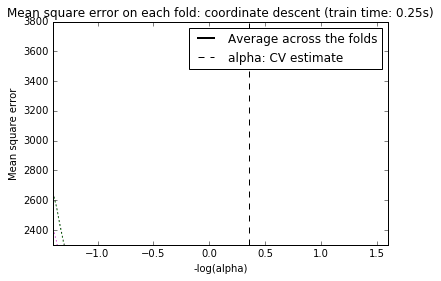

In [74]:
import time
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

In [35]:
from sklearn.linear_model import lasso_path, enet_path
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X,y,eps,fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X,y,eps=eps,l1_ratio=0.8, fit_intercept=False)

Computing regularization path using the elastic net...


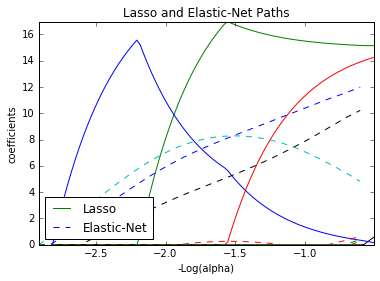

In [39]:
# Display results

plt.figure(1)
ax = plt.gca()
ax.set_color_cycle(2 * ['b', 'r', 'g', 'c', 'k'])
l1 = plt.plot(-np.log10(alphas_lasso), coefs_lasso.T)
l2 = plt.plot(-np.log10(alphas_enet), coefs_enet.T, linestyle='--')
plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('') # Lasso and Elastic-Net Paths
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')
plt.show()

#### [Régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf) ou modèle binomial

La même démarche est déroulée mais en modélisant directement la variable binaire Yb de dépassement ou non du seuil. Il s'agit d'une régression logistique avec toujours une pénalisation Lasso pour opérer une sélection de variables.

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[0.5,1,5,10,12,15,30]}]
logit = GridSearchCV(LogisticRegression(penalty="l1"), param,cv=5,n_jobs=-1)
logitOpt=logit.fit(X_train, Yb_train)
# paramètre optimal
logitOpt.best_params_["C"]

10

In [33]:
# Estimation du modèle optimal et erreur sur l'échantillon test
coefPenal = logitOpt.best_params_["C"]
typePenal="l1"
nproc=-1
logit = LogisticRegression(penalty=typePenal, dual=False, tol=0.0001, 
            C=coefPenal, fit_intercept=True, intercept_scaling=1, 
            class_weight=None, random_state=None, solver='liblinear', 
            max_iter=100, multi_class='ovr', verbose=0, 
            warm_start=False, n_jobs=nproc)
logitFit=logit.fit(X_train, Yb_train)
# Erreur
1-logitFit.score(X_test, Yb_test)

0.12

Le modèle "optimal"  obtenu est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision. 

La matrice de confusion croise les dépassements de seuils prédits avec ceux effectivement observés. 

In [34]:
# Prévision
y_chap = logitFit.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         162  19
1           5  14


L'interprétation du modèle est basée sur les valeurs des coefficients avec les mêmes difficultés ou restrictions que pour la régression.

In [35]:
# Coefficients
logitFit.coef_ 

array([[  0.00000000e+00,  -2.89137650e-01,  -9.12932060e-01,
          0.00000000e+00,   1.69529209e+00,  -1.22471602e+00,
          4.52634693e-03,   4.25398881e-01,  -2.14720918e-01,
          5.21945173e-02,   2.62269316e+01,   1.36143777e+00,
         -1.17856261e+00]])

### 4.3 [K plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf)

Voici un cas d'application d'analyses discriminantes [non paramétriques](http://scikit-learn.org/stable/modules/neighbors.html), celles [paramétriques](http://scikit-learn.org/stable/modules/lda_qda.html) (gaussienes) linéaires et quadratiques sont également présentes dans *scikit-learn*.

Le paramètre de compléxité ($k$) est optimisé sur une grille prédéfinie en minimisant l'erreur estimée par validation croisée; scikit-learn propose de nombreuses options de validation croisée. 

In [36]:
from sklearn.neighbors import KNeighborsClassifier
# Optimisation de k
# grille de valeurs
param=[{"n_neighbors":list(range(1,15))}]
knn=GridSearchCV(KNeighborsClassifier(),param,cv=5,n_jobs=-1)
knnOpt=knn.fit(X_train, Yb_train)
# paramètre optimal
knnOpt.best_params_["n_neighbors"]

5

In [37]:
# k-nn: paramètres et options par défaut
nkk=knnOpt.best_params_["n_neighbors"]
n_proc=-1
knn = KNeighborsClassifier(n_neighbors=nkk, weights='uniform', 
        algorithm='auto', leaf_size=30, p=2, metric='minkowski', 
        metric_params=None, n_jobs=n_proc)
knnFit=knn.fit(X_train, Yb_train) 
# Estimation de l'erreur de prévision
# sur l'échantillon test
1-knnFit.score(X_test,Yb_test)

0.10499999999999998

In [38]:
# Prévision de l'échantillon test
y_chap = knnFit.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         160  14
1           7  19


**Exo:** Compléter les résultats en utilisant la fonction [KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) pour modéliser la concentration; optimiser $k$, calculer la prévision de l'échantillon test, tracer le graphe des résidus, calculer le MSE sur l'échantillon test.

### 4.4. [Arbre binaire de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf)

Les [arbres binaires de décision](http://scikit-learn.org/stable/modules/tree.html) : discrimination ou régression, sont bien implémentés dans *scikit-learn* mais avec une insuffisance pour leur élagage. Ce n'est pas une *pénalisation* de la *complexité*, et donc précisément le nombre de feuilles qui est optimisé, mais la profondeur globale de l'arbre au risque d'élaguer, à une profondeur donnée, des feuilles importantes ou de conserver des feuilles ambigües.

Comme précédemment, la validation croisée permet d'optimiser le paramètre sur une grille.

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeClassifier(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(X_train, Yb_train)
# paramètre optimal
treeOpt.best_params_["max_depth"]

2

Autre difficulté dans la représentation d'un arbre de décision binaire. Le logiciel conseillé (Graphviz) semble délicat d'installation et d'utilisation pour un néophyte. 

In [76]:
# Arbre "optimal"
profMax=treeOpt.best_params_["max_depth"]
## arbre: paramètres et options par défaut
tree=DecisionTreeClassifier(criterion='gini', splitter='best', 
            max_depth=profMax, min_samples_split=2, min_samples_leaf=1, 
            min_weight_fraction_leaf=0.0, max_features=None, 
            random_state=None, max_leaf_nodes=None, class_weight=None, 
            presort=False)
treeFit=tree.fit(X_train, Yb_train) 
# Estimation de l'erreur de prévision
1-treeFit.score(X_test,Yb_test)

0.15500000000000003

In [77]:
# prévision de l'échantillon test
y_chap = treeFit.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         162  26
1           5   7


**Exo:** Compléter les résultats en utilisant la fonction [DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) pour modéliser concentration; optimiser la profondeur, calculer la prévision de l'échantillon test, tracer les résidus, calculer le MSE sur l'échantillon test.

### 4.5 [Réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf)

Les réseaux neuronaux ne sont pas présents dans le package scikit-learn qu'à partir de la version 0.18 encore en développement lors de la mise en place de ce calepin et donc pas disponible dans les distributions faciles à installer. La fonction "perceptron" n'en est pas un mais un modèle linéaire avec une fonction objectif spécifique. Il existe par ailleurs, [pybrain](http://pybrain.org/) mais qui semble-t-il n'est plus maintenu, [neurolab](https://code.google.com/archive/p/neurolab/), [theano](http://deeplearning.net/software/theano/) et [Lasagne](http://lasagne.readthedocs.io/en/latest/index.html) qui proposent de l"apprentissage profond" (*deep learning*) mais ce dernier est beaucoup plus complexe d'installation et d'utilisation au regard de la simplicité du problème posé: carte graphique pour parallélliser (GPU), génération de code C... Cette section sera complétée avec la disponibilité de la versions 0.18.

### 4.6 [Forêts aléatoires](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

La librairie *randomForest* de R utilise le programme historique développé par [Breiman et Cutler](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_software.htm)(2001) et interfacé  par [Liaw et Wiener](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf). Cette interface est toujours mise à jour mais il n'est pas sûr que le programme original continue d'évoluer depuis 2004. Pour des tailles importantes d'échantillons, quelques milliers, cette implémentation atteint des temps d'exécution rédhibitoires (cf. cet [exemple](http://wikistat.fr/pdf/st-atelier-MINST.pdf)) au contraire de celle en Python dont gestion mémoire et capacité de parallélisation ont été finement optimisées par [Louppe et al.](http://fr.slideshare.net/glouppe/accelerating-random-forests-in-scikitlearn)(2014). 

De même que le boosting, deux fonctions  de forêt sont proposés dans [scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html) ; une pour la régression et une pour la classification ainsi qu'une version "plus aléatoire". Par rapport à la version originale de R, moins d'options sont proposées mais l'utilisation de base est très similaire avec le même jeu de paramètres.

In [42]:
from sklearn.ensemble import RandomForestClassifier 
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, 
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train,Yb_train)
print(1-rfFit.oob_score_)

0.114149821641


Comparer l'erreur out-of-bag ci-dessus avec celle sur l'échantillon test.

In [43]:
# erreur de prévision sur le test
1-rfFit.score(X_test,Yb_test)

0.10499999999999998

Optimisation par validation croisée du nombre de variables tirés aléatoirement lors de la construction de chaque noeud. 

In [44]:
from sklearn.grid_search import GridSearchCV
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestClassifier(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(X_train, Yb_train)
# paramètre optimal
rfOpt.best_params_['max_features']

3

Plusieurs exécutions, rendues aléatoires par la validation croisée, peuvent conduire à des valeurs "optimales" différentes de ce paramètre sans pour autant nuire à la qualité de prévision sur l'échantillon test.

In [45]:
nb_var=rfOpt.best_params_['max_features']
rf = RandomForestClassifier(n_estimators=500,
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features=nb_var,max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFit = rf.fit(X_train,Yb_train)
# erreur de prévision sur le test
1-rfFit.score(X_test,Yb_test)

0.10499999999999998

**Exo:** Tester différentes valeurs de *min_samples_split* de celle trouvée optimale. Conclusion sur la sensibilité de l'optimisation de ce paramètre ?

In [46]:
# prévision
y_chap = rfFit.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         165  19
1           2  14


Comme avec R, il est possible de calculer un indicateur d'importance des variables pour aider à une forme d'interprétation. Celui-ci dépend de la position de la variable dans l'arbre et correspond donc au *mean decrease in Gini index* de R plutôt qu'au *mean descrease in accuracy*. 

In [47]:
# Importance décroissante des variables
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(dfC.columns[indices[f]], importances[indices[f]])

('TEMPE', 0.29213617349085302)
('MOCAGE', 0.17385637412630589)
('SRMH2O', 0.11758219986360663)
('VentANG', 0.099688759089973877)
('VentMOD', 0.084750765485227142)
('LNO2', 0.08418233276286001)
('LNO', 0.080200598508863866)
('STATION_Cad', 0.019266561904651845)
('STATION_Pla', 0.013592892140683089)
('JOUR_1', 0.010766651736123421)
('STATION_Als', 0.0098326370641070582)
('STATION_Aix', 0.0078378300432891644)
('STATION_Ram', 0.0063062237834549516)


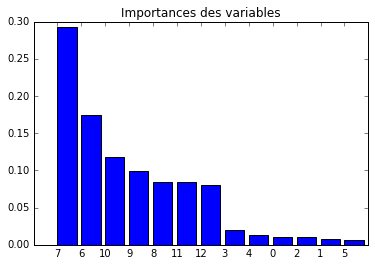

In [48]:
# Graphe des importances
plt.figure()
plt.title("Importances des variables")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

**Exo:** Comparer les importances des variables et les sélections opérées précédemment. 

**Exo:** Remplacer ensuite la fonction RandomForestClassifier par celle [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) de régression. Optimiser le paramètre, calculer la prévision, les résidus, le MSE.

**Exo:** Expérimenter également le boosting sur ces données en exécutant la fonction [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) opérant l'agorithme de *gradient tree boosting*. 

*Remarque:* Cet algorithme est également proposé dans un autre package: [](https://xgboost.readthedocs.io/en/latest/build.html#python-package-installation) qui peut être utilisé à partir de Python mais aussi R, Julia ou Java.

### 4.7 [*Support Vector Machine*](http://wikistat.fr/pdf/st-m-app-svm.pdf)

De nombreux paramètres sont associés à cette méthode. La liste est à consulter dans la [documentation](http://scikit-learn.org/stable/modules/svm.html) en ligne.

L'optimisation de la pénalisation (paramètre C) est recherchée sur une grille par validation croisée. Remarque: il serait nécessaire d'optimiser également la valeur du coefficient *gamma* lié au noyau gaussien ("écart-type").

In [49]:
from sklearn.svm import SVC
param=[{"C":[0.4,0.5,0.6,0.8,1,1.4]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(X_train, Yb_train)
# paramètre optimal
svmOpt.best_params_["C"]

0.5

In [50]:
penal=svmOpt.best_params_["C"]
svm=SVC(C=penal, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
    max_iter=20, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svmFit=svm.fit(X_train, Yb_train)
# erreur de prévision sur le test
1-svmFit.score(X_test,Yb_test)

D:\Users\pbesse\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\svm\base.py:224: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.17500000000000004

**Exo:** Un "warning" apparaît. Remplacer les variables quantitatives de la matrice X_train par leur version centrée et réduite comme suggéré. 

In [51]:
# prévision de l'échantillon test
y_chap = svm.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         161  29
1           6   4


**Exo** Comme précédemment, remplacer ensuite la fonction SVC par celle [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) de régression. Optimiser le paramètre, calculer la prévision, les résidus; le MSE.

## 5.1 Comparaison des méthodes

### 5.1 Courbes ROC

Dans toute méthode, la prévision de dépassement ou non est associée au choix d'un seuil qui est par défaut 0.5. L'optimisaiton de ce seuil dépend des coûts respectifs associés aux faux positifs et aux faux négatifs qui ne sont pas nécessairement égaux. La courbe ROC permet de représenter l'influence de ce seuil sur les taux de faux positifs et vrais positifs.  

In [52]:
from sklearn import metrics
listMethod=[["SVM",svm],["RF",rf],["Tree",tree],["K-nn",knn],["Logit",logit]]

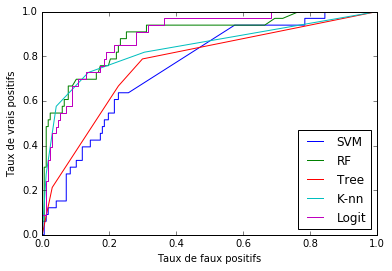

In [53]:
for method in enumerate(listMethod):
    probas_ = method[1][1].fit(X_train, Yb_train).predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(Yb_test, probas_[:,1])
    plt.plot(fpr, tpr, lw=1,label="%s"%method[1][0])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc="best")
plt.show()

Comme les courbes peuvent généralement se croiser, le critère d'AUC (aire sous la courbe) ne permet pas d'ordonner les courbes et donc les méthodes. C'est à un taux de faux positif admissible et donc à valeur de seuil fixé qu'il faut choisir la méthode d'apprentissage à privilégier. 

### 5.2 Itération sur plusieurs échantillons de test

L'échantillon test est de taille modeste et donc l'estimation de l'erreur de prévision peut présenter une variance importante. Celle-ci est réduite en opérant une forme de validation croisée en tirant plusieurs couples d'échantillon apprentissage et test pour itérer les traitements précédents.

Les fonctionnalités de scikit-learn se prètent bien à l'automatisation de ces traitements enchaînant extraction d'échantillons, estimation de plusieurs modèles, optimisation de leurs paramètres et estimation de l'erreur de prévision sur le test.

Le code est compact et d'exécution efficace car bien parallélisé par les fonctions utilisées.

In [57]:
from sklearn.utils import check_random_state
import time
check_random_state(13)
tps0=time.clock()
# Nombre d'itérations
B=30 # pour tester le programme, mettre plutôt B=30
# définition des grilles de paramètres
listMethGrid=[[svm,{"C":[0.4,0.5,0.6,0.8,1,1.4]}],
    [rf,{"max_features":list(range(2,10,2))}],
    [tree,{"max_depth":list(range(2,10))}],
    [knn,{"n_neighbors":list(range(1,15))}],
    [logit,{"C":[0.5,1,5,10,12,15,30]}]]
# Initialisation à 0 des erreurs pour chaque méthode (colonne) et chaque itération (ligne)
arrayErreur=np.empty((B,5))
for i in range(B):   # itérations sur B échantillons test
    # extraction apprentissage et test
    X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=200)
    # optimisation de chaque méthode et calcul de l'erreur sur le test
    for j,(method, grid_list) in enumerate(listMethGrid):
        methodGrid=GridSearchCV(method,grid_list,cv=10,n_jobs=-1).fit(X_train, Yb_train)
        methodOpt = methodGrid.best_estimator_
        methFit=methodOpt.fit(X_train, Yb_train)
        arrayErreur[i,j]=1-methFit.score(X_test,Yb_test)
tps1=time.clock()
print("Temps execution en mn :",(tps1 - tps0)/60)
dataframeErreur=pd.DataFrame(arrayErreur,columns=["SVM","RF","Tree","Knn","Logit"])    

('Temps execution en mn :', 29.30802809871614)


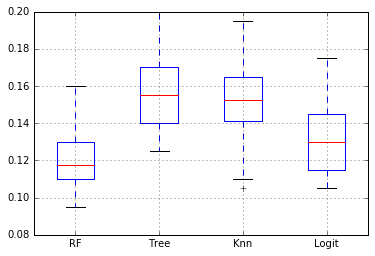

In [58]:
# Distribution des erreurs de prévisions
# Les SVM présentant des erreurs atypiques sont laissés de côté.
dataframeErreur[["RF","Tree","Knn","Logit"]].boxplot(return_type='dict')
plt.show()

In [56]:
dataframeErreur.mean()

SVM      0.1550
RF       0.0950
Tree     0.1300
Knn      0.1450
Logit    0.1175
dtype: float64

## Conclusion

Cet exemple, traité en R puis en Python, résume bien l'intérêt et le contexte des méthodes d'apprentissage.
* Par rapport à la *base line* : prévision MOCAGE présentant un taux moyen d'erreur de 30%, un modèle statistique élémentaire améliore très sensiblement le résultat.
* Une méthode plus sophistiquée, ici *random forest* apporte une amélioration statistiquement significative mais assez faible au prix de l'interprétation fine des résultats.
* Python, outil d'*apprentissage machine*, est beaucoup plus efficace : 28' au lieu de plusieurs heures avec R pour les dernières simulations sur un *laptop* 4 coeurs et 8GO de RAM.
* En revanche, R, outil d'*apprentissage statistique*, permet la sélection et l'interprétation des variables et de leurs **interactions** pour un modèle de régression linéaire ou logistique classique. La prise en compte d'interactions (modèle quadratique) améliore sensiblement la qualité des prévisions.
* Les forêts aléatoires font mieux sur cet exemple, c'est souvent le cas comme avec le *boosting*, mais d'autres exemples mettent en avant d'autres méthodes: neurones pour une modélisation physique, SVM pour du criblage virtuelle de molécules, régression PLS pour la spectrométrie en proche infra-rouge (NIR)... pas de règle générale.
* Jupyter est un support pédagogique efficace pour des analyses sans développement volumineux de code.
* Avant d'éventuellement passer à [Julia](http://julialang.org/), R et Python sont à l'usage très complémentaires.
